In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lib.dataset_utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from transformers import BertTokenizer,AutoTokenizer, RobertaTokenizer

### Load Data

In [2]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
label_names = train_df.columns[1:]

In [3]:
train_df.head(20)

,text,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
5,ive been feeling a little burdened lately wasn...,0,0,0,0,1,0
6,ive been taking or milligrams or times recomme...,0,0,0,0,0,1
7,i feel as confused about life as a teenager or...,0,1,0,0,0,0
8,i have been with petronas for years i feel tha...,0,0,1,0,0,0
9,i feel romantic too,0,0,0,1,0,0


### Explore Data

In [4]:
train_df.isna().sum()

text        0
anger       0
fear        0
joy         0
love        0
sadness     0
surprise    0
dtype: int64

No nan found

### Twitter mentions and hashtags

In [5]:
# find twitter mentions and hashtags
occ = train_df['text'].str.findall(r'@(\w+)|#(\w+)')
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()

array([], dtype=object)

Very few records have user tags and reddit tags

### Links in text

In [6]:
# find links in the text
occ = train_df['text'].str.findall(r"(?: ^|\b)https?://\S+")
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)
occ = train_df['text'].str.findall(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)')
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)

Series([], dtype: object)
Series([], dtype: object)


Sampling data, we found that links are present, but exist related to whitespaced tokens href, http, www

In [7]:
# get number of records with at least one tag
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f'{name}: {len(dataset[dataset["text"].str.contains(r"(?: href|http|www)", regex=True)])}')

train: 203
val: 25
test: 26


In [8]:
# retrieve records
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f'{name}: {dataset[dataset["text"].str.contains(r"(?: href|http|www)", regex=True)]}')

train:                                                     text  anger  fear  joy  \
125    i feel they are pretty safe on my blog img src...      0     0    1   
323    i stopped feeling so exhausted a href http pro...      0     0    0   
462                  i feel so dazed a href http twitter      0     0    0   
640                          i feel so carefree nowwwwww      0     0    1   
866    i feel unwelcome at work sometimes and think p...      0     0    0   
...                                                  ...    ...   ...  ...   
15509        i feel like i should be offended but yawwwn      1     0    0   
15518  i feel honoured to be asked thanks a href http...      0     0    1   
15732  i feel like it was just a title mimm fall insp...      0     0    1   
15779  i cant always identify with peoples struggles ...      0     0    0   
15784  i get the added bonus of feeling superior and ...      0     0    1   

       love  sadness  surprise  
125       0        0   

In [9]:
occ = train_df[train_df["text"].str.contains(r"(?: href|http|(?: ^|\b)www(?: $|\b))", regex=True)]
occ

,text,anger,fear,joy,love,sadness,surprise
125,i feel they are pretty safe on my blog img src...,0,0,1,0,0,0
323,i stopped feeling so exhausted a href http pro...,0,0,0,0,1,0
462,i feel so dazed a href http twitter,0,0,0,0,0,1
866,i feel unwelcome at work sometimes and think p...,0,0,0,0,1,0
967,i a href http feeling groggy,0,0,0,0,1,0
...,...,...,...,...,...,...,...
15344,i feel more confident already a href http john...,0,0,1,0,0,0
15518,i feel honoured to be asked thanks a href http...,0,0,1,0,0,0
15732,i feel like it was just a title mimm fall insp...,0,0,1,0,0,0
15779,i cant always identify with peoples struggles ...,0,0,0,0,1,0


links follow a rather strange pattern of tokens:
a href http 'link'

### Distribution of text and labels over the split

#### Label Balance

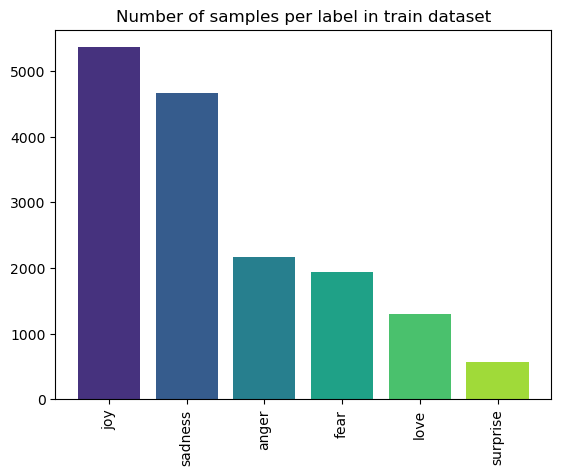

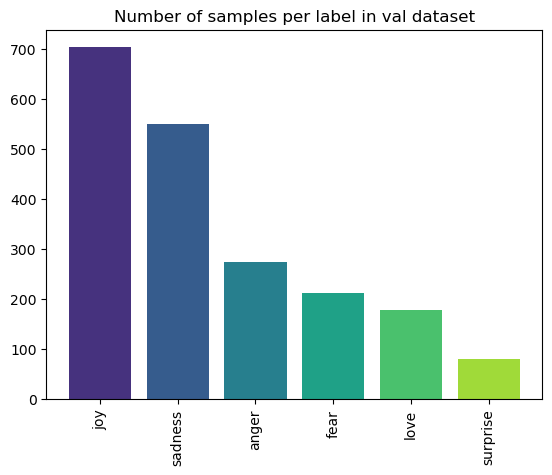

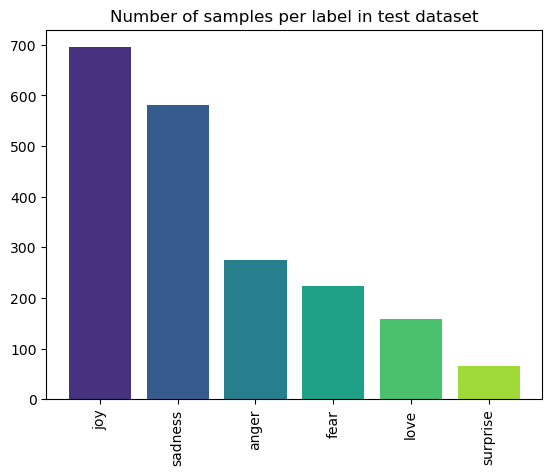

In [10]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # bar plot of the number of samples per label
    dataset_labels = dataset[label_names].values
    counts = np.sum(dataset_labels, axis=0)
    # sort by counts
    sorted_idx = np.argsort(counts)[::-1]
    sorted_label_names = label_names[sorted_idx]
    counts = counts[sorted_idx]
    plt.bar(sorted_label_names, counts, color=sns.color_palette("viridis", len(sorted_label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Number of samples per label in {name} dataset')
    plt.show()

#### Text Length and word count

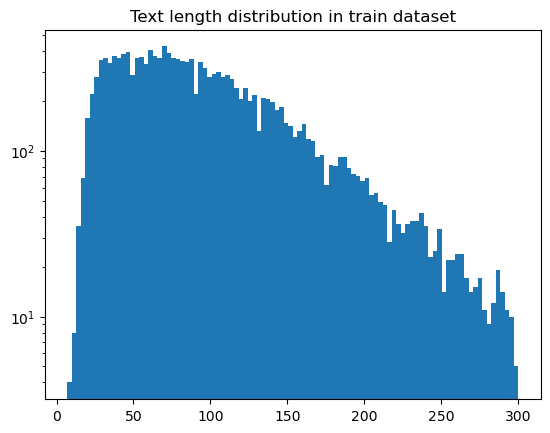

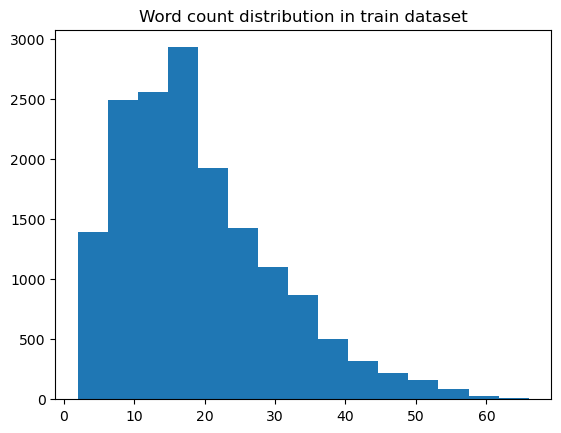

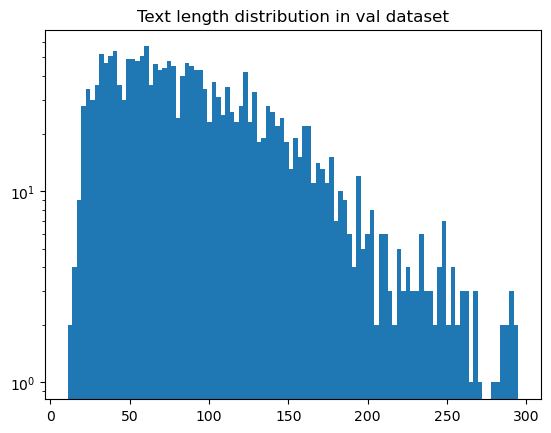

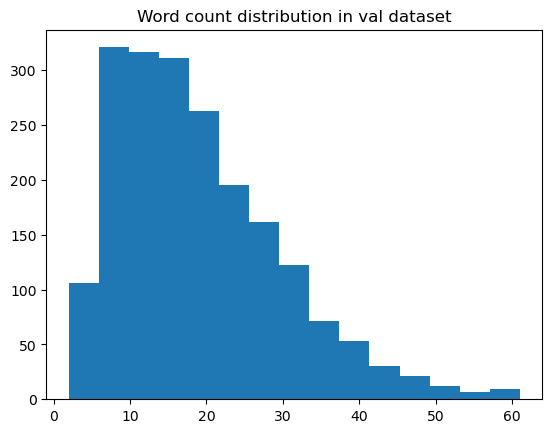

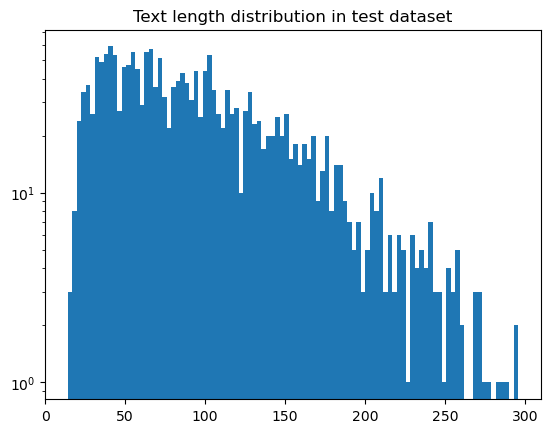

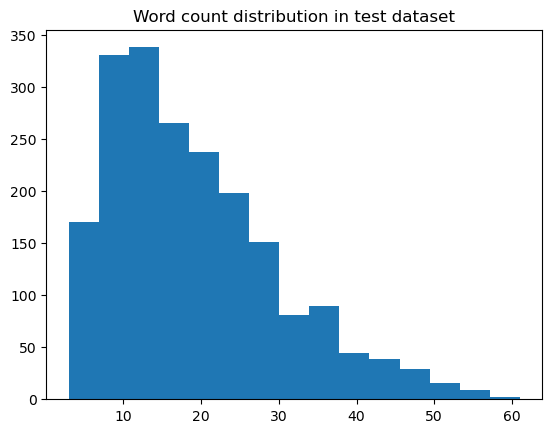

In [11]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # text length histogram
    dataset['text_len'] = dataset['text'].apply(lambda x: len(x))
    dataset['text_len'].hist(bins=100)
    plt.title(f'Text length distribution in {name} dataset')
    plt.yscale('log')
    plt.grid(False)
    plt.show()
    # word count histogram
    dataset['word_count'] = dataset['text'].apply(lambda x: len(x.split()))
    dataset['word_count'].hist(bins=15)
    plt.title(f'Word count distribution in {name} dataset')
    plt.grid(False)
    plt.show()

#### Text length and word count by label

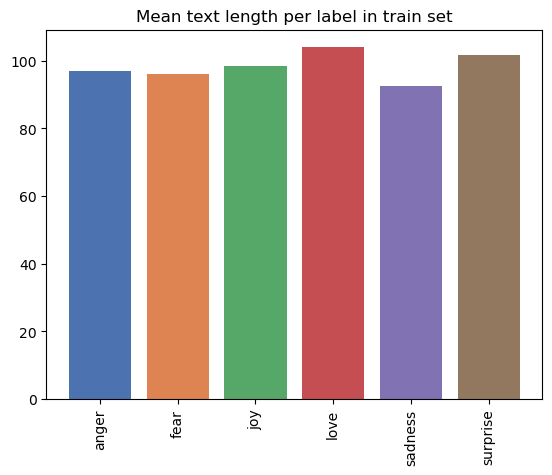

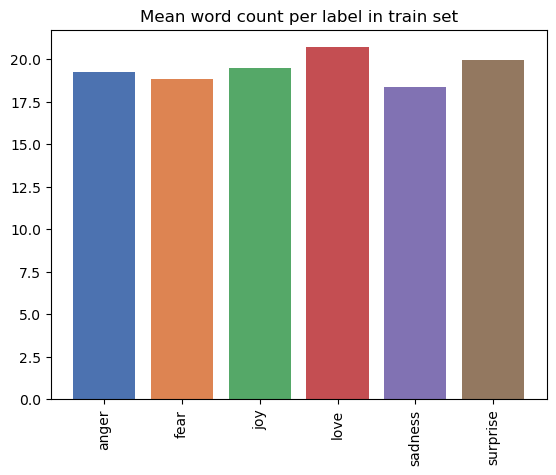

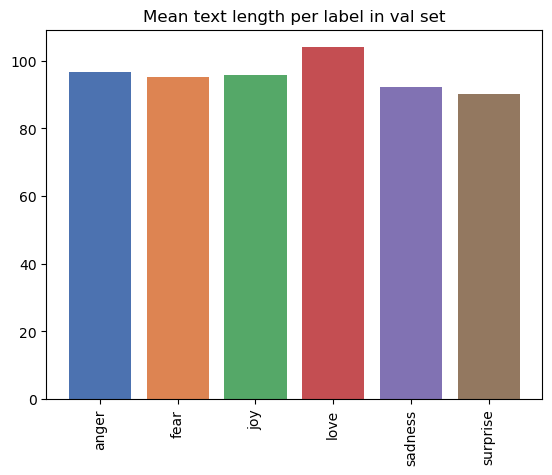

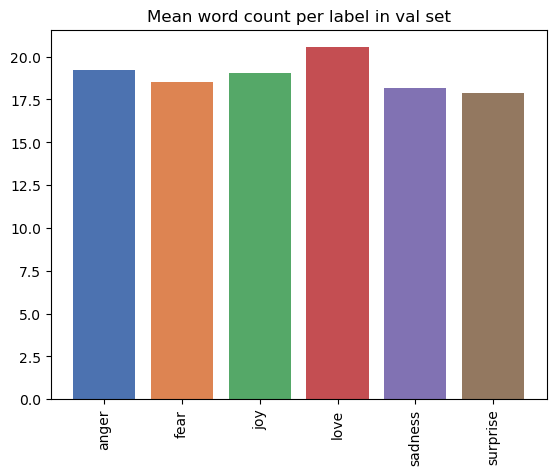

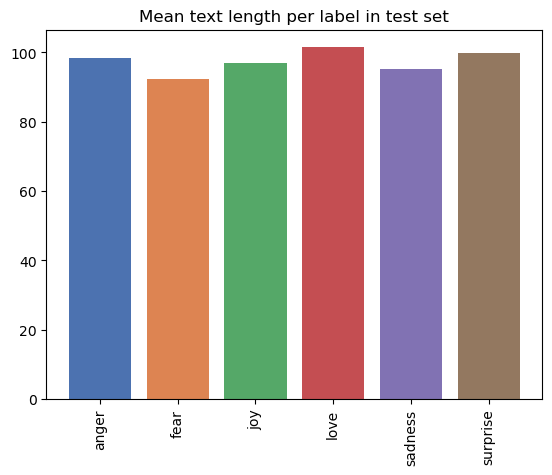

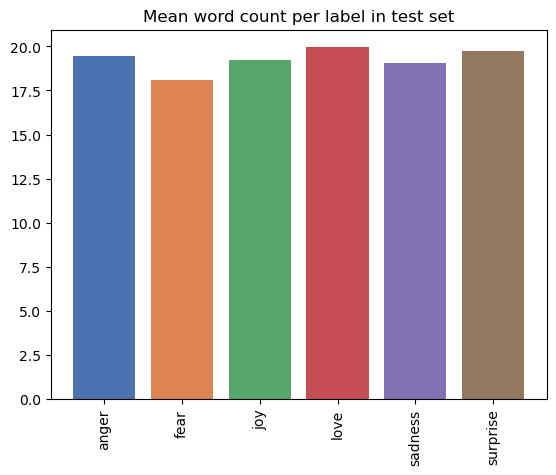

In [12]:
# mean text length per label and word count per label
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    avg_text_len = []
    avg_word_count = []
    for label in label_names:
        label_mask = dataset[label] == 1
        label_text_len = dataset[label_mask]['text_len']
        label_word_count = dataset[label_mask]['word_count']
        avg_text_len.append(np.mean(label_text_len))
        avg_word_count.append(np.mean(label_word_count))
    plt.bar(label_names, avg_text_len, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Mean text length per label in {name} set')
    plt.show()
    plt.bar(label_names, avg_word_count, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Mean word count per label in {name} set')
    plt.show()

## Token count

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


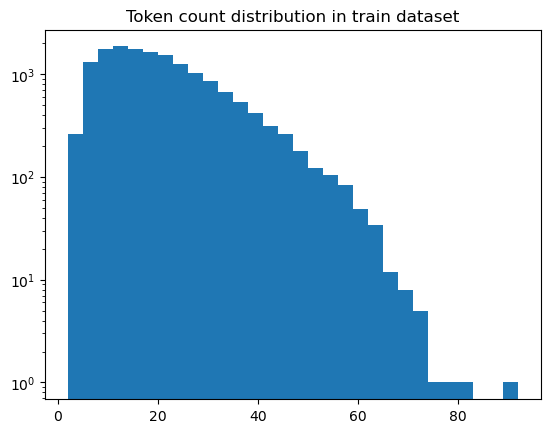

max token count in train dataset: 92


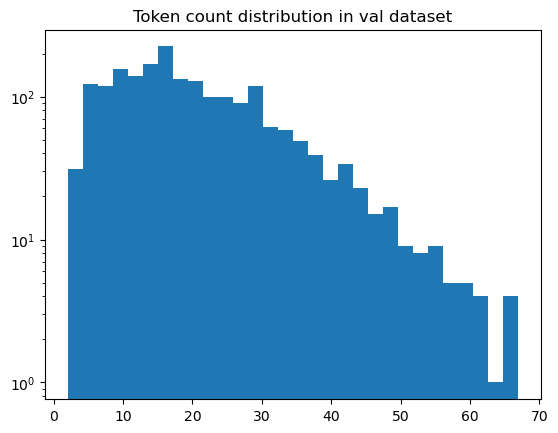

max token count in val dataset: 67


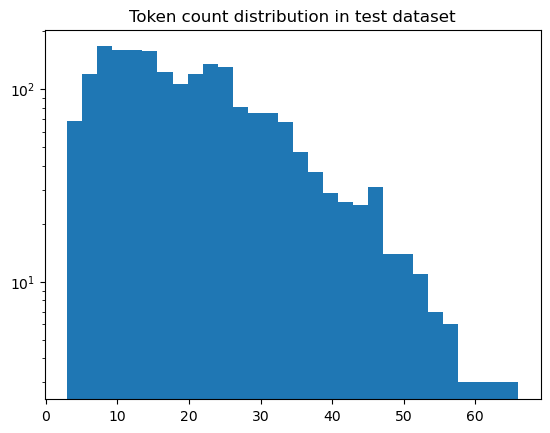

max token count in test dataset: 66


In [13]:
# count token count distribution using bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
token_counts_dict = {}
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    token_counts = []
    for text in dataset['text']:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
    plt.hist(token_counts, bins=30)
    plt.title(f'Token count distribution in {name} dataset')
    plt.grid(False)
    plt.yscale('log')
    plt.show()
    print(f'max token count in {name} dataset: {max(token_counts)}')
    token_counts_dict[name] = token_counts

In [14]:
#get sentences with high token count
occ = train_df[[el > 70 for el in token_counts_dict['train']]]
occ

,text,anger,fear,joy,love,sadness,surprise,text_len,word_count
2881,i like to notify that i all the time feel my s...,0,0,0,1,0,0,274,55
4514,i is celebrated with great fan fare which happ...,0,0,0,0,1,0,286,50
6322,i guess which meant or so i assume no photos n...,0,0,0,0,1,0,291,66
7222,i am happier this year in all ways i am just g...,0,0,1,0,0,0,291,64
9618,i feel you i dont believ in you but i keep my ...,0,0,1,0,0,0,296,64
9753,i just feel you so so dont be afraid naega deo...,0,1,0,0,0,0,259,49
11400,i have been using deborah lippmann hard rock a...,0,0,1,0,0,0,293,57
14644,i feel lethargic and getting pressure between ...,0,0,0,0,1,0,215,29
15791,i watch iggy azealea strutting down a desert r...,0,0,1,0,0,0,281,54


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


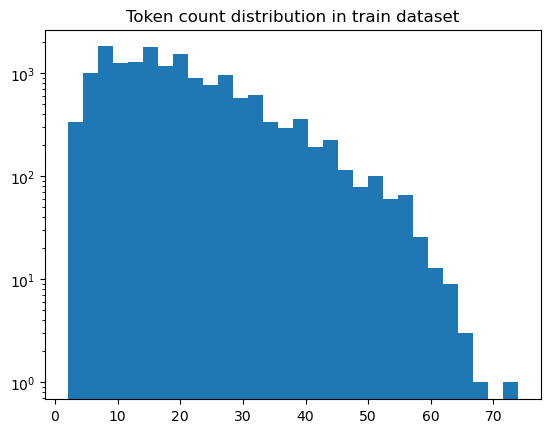

max token count in train dataset: 74


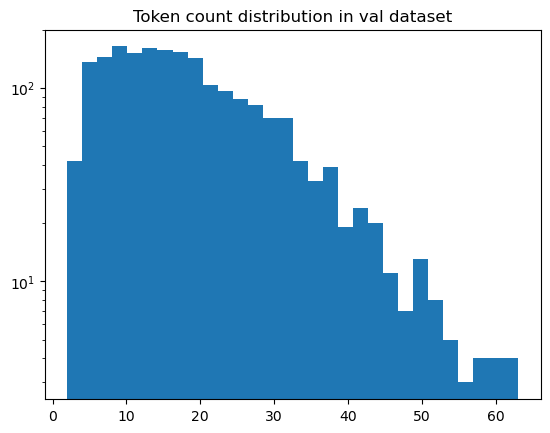

max token count in val dataset: 63


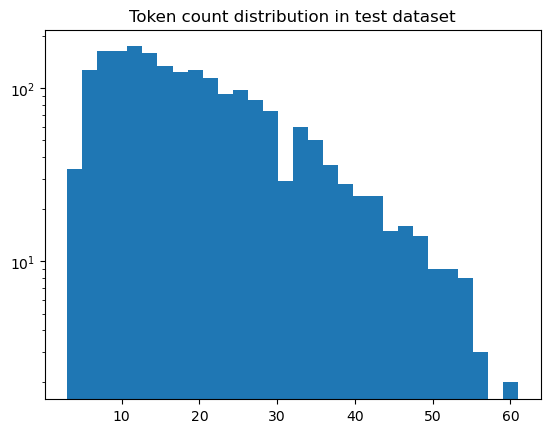

max token count in test dataset: 61


In [15]:
# SocBert count token count distribution using bert tokenizer
tokenizer = AutoTokenizer.from_pretrained("sarkerlab/SocBERT-base")
token_counts_dict = {}
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    token_counts = []
    for text in dataset['text']:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
    plt.hist(token_counts, bins=30)
    plt.title(f'Token count distribution in {name} dataset')
    plt.grid(False)
    plt.yscale('log')
    plt.show()
    print(f'max token count in {name} dataset: {max(token_counts)}')
    token_counts_dict[name] = token_counts

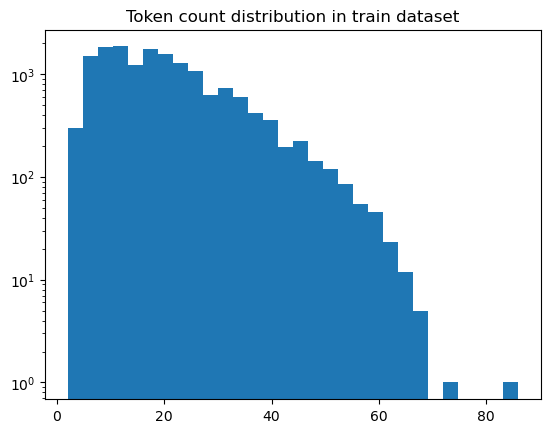

max token count in train dataset: 86


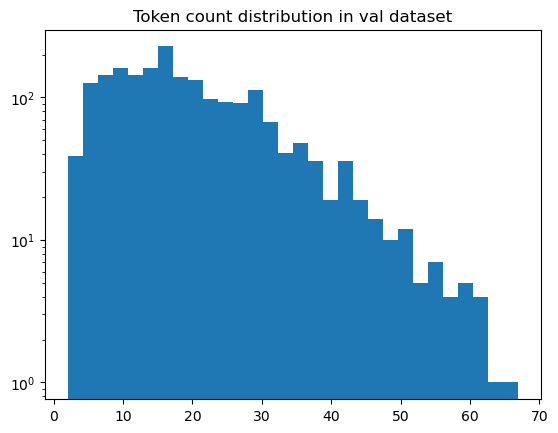

max token count in val dataset: 67


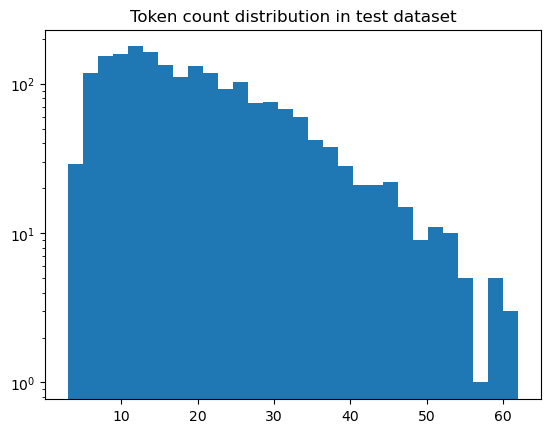

max token count in test dataset: 62


In [16]:
# count token count distribution using bert tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
token_counts_dict = {}
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    token_counts = []
    for text in dataset['text']:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
    plt.hist(token_counts, bins=30)
    plt.title(f'Token count distribution in {name} dataset')
    plt.grid(False)
    plt.yscale('log')
    plt.show()
    print(f'max token count in {name} dataset: {max(token_counts)}')
    token_counts_dict[name] = token_counts

## Long sequences of same character

In [17]:
ids = train_df['text'].str.extract(r'(.)\1{5,}').dropna().index
train_df.loc[ids]

,text,anger,fear,joy,love,sadness,surprise,text_len,word_count
276,i am so festive this feels so delicious wheeee...,0,0,1,0,0,0,67,13
474,i knew it was the holy spirit at work plus it ...,0,0,1,0,0,0,107,22
640,i feel so carefree nowwwwww,0,0,1,0,0,0,27,5
3721,i thought id talk today about getting cold fee...,1,0,0,0,0,0,239,45
3787,i feel that sometimes my lessons are too borin...,0,0,0,0,1,0,206,42
3837,i feel too much but i don t care no i don t ca...,1,0,0,0,0,0,113,26
7222,i am happier this year in all ways i am just g...,0,0,1,0,0,0,291,64
8205,i just read this on yahoo and thought it verrr...,0,0,0,1,0,0,156,32
9112,i left feeling hopeful given i had felt some r...,0,0,1,0,0,0,83,14
9505,i just feel sooooooooooo fucked up at this moment,1,0,0,0,0,0,49,9
